In [1]:
from IPython.display import clear_output

!pip install --upgrade tensorflow
!pip install --upgrade keras

!pip install plotly
!pip install glob2

clear_output()
print("Tensorflow and Keras are Updated. Plotly and Glob are installed.")

Tensorflow and Keras are Updated. Plotly and Glob are installed.


In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import pytesseract as pt
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet

from glob import glob
from skimage import io
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
path1 = glob('/kaggle/input/arlp-datasets/ARLP Datasets ver-2/train/*.xml')
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
for filename in path1:
    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

In [5]:
df = pd.DataFrame(labels_dict)
df.to_csv('labels.csv',index=False)
df

filepath  xmin  xmax  ymin  \
0     /kaggle/input/arlp-datasets/ARLP Datasets ver-...   209   283   135   
1     /kaggle/input/arlp-datasets/ARLP Datasets ver-...   191   242   147   
2     /kaggle/input/arlp-datasets/ARLP Datasets ver-...   244   369   240   
3     /kaggle/input/arlp-datasets/ARLP Datasets ver-...   331   538   263   
4     /kaggle/input/arlp-datasets/ARLP Datasets ver-...   115   277   115   
...                                                 ...   ...   ...   ...   
1220  /kaggle/input/arlp-datasets/ARLP Datasets ver-...   354   656   481   
1221  /kaggle/input/arlp-datasets/ARLP Datasets ver-...   622   789   726   
1222  /kaggle/input/arlp-datasets/ARLP Datasets ver-...   257   499   704   
1223  /kaggle/input/arlp-datasets/ARLP Datasets ver-...    38   146   225   
1224  /kaggle/input/arlp-datasets/ARLP Datasets ver-...   321   559   420   

      ymax  
0      169  
1      169  
2      293  
3      317  
4      153  
...    ...  
1220   564  
1221   875  
1222   759  
1223   249  
1224   484  

[1225 rows x 5 columns]

In [ ]:
filename = df['filepath'][0]
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join('/kaggle/input/arlp-datasets/ARLP Datasets ver-2/train',filename_image)
    return filepath_image
getFilename(filename)

'/kaggle/input/arlp-datasets/ARLP Datasets ver-2/train/Cars339.png'

In [7]:
image_path = list(df['filepath'].apply(getFilename))
# image_path = image_path
# image_path = image_path[:25]

# Pre-processing

In [8]:
labels = df.iloc[:,1:].values
data = []
output = []
for ind in range(len(image_path)):
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape

    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0

    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax)

    data.append(norm_load_image_arr)
    output.append(label_norm)

In [9]:
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

In [10]:
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((980, 224, 224, 3), (245, 224, 224, 3), (980, 4), (245, 4))

# ARLP Custom CNN model

In [12]:
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, MaxPooling2D, Flatten, multiply, Dense, Reshape, BatchNormalization, add, Activation, GlobalAveragePooling2D, Multiply, Concatenate, Lambda, Layer
from tensorflow.keras.activations import swish
import tensorflow.keras.backend as K

@tf.keras.utils.register_keras_serializable()
class SpatialAttention(Layer):
    def __init__(self, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)
        self.avg_pooling = GlobalAveragePooling2D()
        self.conv = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer='he_normal')

    def build(self, input_shape):
        self.conv.build((None, None, None, input_shape[-1] * 2))
        super(SpatialAttention, self).build(input_shape)

    def call(self, inputs):
        avg_pool = self.avg_pooling(inputs)
        max_pool = self.avg_pooling(inputs)
        avg_pool = K.expand_dims(K.expand_dims(avg_pool, axis=1), axis=1)
        max_pool = K.expand_dims(K.expand_dims(max_pool, axis=1), axis=1)
        concat = Concatenate(axis=3)([avg_pool, max_pool])
        spatial_attention = self.conv(concat)
        return spatial_attention

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[1], input_shape[2], 1

    
def cbam_block(input_feature, ratio=8):
    channel = input_feature.shape[-1]
    shared_dense_one = Dense(channel//ratio, activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    shared_dense_two = Dense(channel, kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')

    # Channel Attention
    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = shared_dense_one(avg_pool)
    avg_pool = shared_dense_two(avg_pool)
    max_pool = GlobalAveragePooling2D()(input_feature)
    max_pool = shared_dense_one(max_pool)
    max_pool = shared_dense_two(max_pool)
    cbam_feature = add([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    # Spatial Attention
    spatial_attention = SpatialAttention()(input_feature)

    return Multiply()([input_feature, cbam_feature, spatial_attention])


# Inception-V4 inspired initial stem
def inception_v4_stem(input_tensor):
    x = Conv2D(32, (3, 3), strides=2, padding='same', activation=swish)(input_tensor)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation=swish, padding='same')(x)
    x = BatchNormalization()(x)
    return x

# Squeeze-and-Excitation Block
def se_block(input_tensor, ratio=16):
    filters = input_tensor.shape[-1]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', use_bias=False)(se)
    x = multiply([input_tensor, se])
    return x

# Dual Path Block
def dpn_block(x, filters):
    # Path 1: Dense path
    d1 = Conv2D(filters, (1, 1), activation=swish, padding='same')(x)
    d1 = BatchNormalization()(d1)
    d1 = Conv2D(filters, (3, 3), activation=swish, padding='same')(d1)
    d1 = BatchNormalization()(d1)

    # Path 2: Residual path
    r1 = Conv2D(filters, (1, 1), activation=swish, padding='same')(x)
    r1 = BatchNormalization()(r1)

    # Combine paths
    combined = Concatenate()([d1, r1])
    combined = Conv2D(filters, (1, 1), activation=swish)(combined)
    combined = BatchNormalization()(combined)
    return combined

# Updated Inception-ResNet Block with Swish Activation
def inception_resnet_block(x, filters):
    b1 = Conv2D(filters, (1, 1), activation=swish, padding='same')(x)
    b1 = BatchNormalization()(b1)

    b2 = Conv2D(filters, (1, 1), activation=swish, padding='same')(x)
    b2 = BatchNormalization()(b2)
    b2 = DepthwiseConv2D((3, 3), activation=swish, padding='same')(b2)
    b2 = BatchNormalization()(b2)

    x = Concatenate()([b1, b2])
    x = Conv2D(filters, (1, 1), activation=None)(x)
    x = BatchNormalization()(x)
    x = add([x, b1])  # Add residual connection from branch 1
    x = Activation(swish)(x)
    return x

from tensorflow.keras import Model

inputs = Input(shape=(224, 224, 3))
x = Conv2D(64, (7, 7), strides=2, activation=swish, padding='same')(inputs)
x = MaxPooling2D((3, 3), strides=2, padding='same')(x)
x = inception_v4_stem(x)

for f in [64, 128, 256, 512, 1024]:
    for i in range(4): 
        x = inception_resnet_block(x, f)
        x = dpn_block(x, f)
    x = se_block(x)
    x = cbam_block(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

x = Flatten()(x)
x = Dense(1024, activation=swish)(x)
x = Dropout(0.5)(x)
x = Dense(512, activation=swish)(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=output)

In [13]:
model.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

model.name = "ARLP_Custom_CNN"
model.summary() # Comment this line if you don't want the summary.

Model: "ARLP_Custom_CNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │     18,464 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 28, 28,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │      4,160 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │      4,160 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 28, 28,    │        640 │ batch_normalizat… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Concatenate)       │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 28, 28,    │      8,256 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 28, 28,    │          0 │ batch_normalizat

 Total params: 96,127,521 (366.70 MB)

 Trainable params: 96,000,353 (366.21 MB)

 Non-trainable params: 127,168 (496.75 KB)

In [14]:
total_params = model.count_params()
print("Total number of parameters:", total_params)

total_size_mb = total_params * 4 / (1024 * 1024)
print("Rough estimation of model size:", total_size_mb, "MB")

Total number of parameters: 96127521
Rough estimation of model size: 366.69739151000977 MB


In [17]:
# x_train = x_train[:10]
# y_train = y_train[:10]
BATCHSIZE = 64
EPOCHS = 100

In [ ]:
history = model.fit(x=x_train,
                    y=y_train,
                    batch_size=BATCHSIZE,
                    epochs=EPOCHS,
                    validation_data=(x_test,y_test))

Epoch 1/100


I0000 00:00:1714971569.198902     479 service.cc:145] XLA service 0x7f0604008c00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714971569.198956     479 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1714971670.050575     479 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_50', 224 bytes spill stores, 224 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_49', 224 bytes spill stores, 224 bytes spill loads

I0000 00:00:1714971670.189245     479 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16/16 ━━━━━━━━━━━━━━━━━━━━ 339s 9s/step - accuracy: 0.3639 - loss: 0.0383 - val_accuracy: 0.5918 - val_loss: 0.0460
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - accuracy: 0.5754 - loss: 0.0291 - val_accuracy: 0.0000e+00 - val_loss: 0.0461
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 216ms/step - accuracy: 0.5314 - loss: 0.0282 - val_accuracy: 0.0000e+00 - val_loss: 0.0458
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step - accuracy: 0.5769 - loss: 0.0285 - val_accuracy: 0.0000e+00 - val_loss: 0.0454
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 218ms/step - accuracy: 0.5997 - loss: 0.0291 - val_accuracy: 0.0000e+00 - val_loss: 0.0449
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step - accuracy: 0.5387 - loss: 0.0301 - val_accuracy: 0.5918 - val_loss: 0.0442
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 219ms/step - accuracy: 0.5819 - loss: 0.0293 - val_accuracy: 0.5918 - val_loss: 0.0430
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 223ms/step - accuracy: 0.5797 - loss: 0.0268 - val_a

# Model Analysis

8/8 - 12s - 1s/step - accuracy: 0.6449 - loss: 0.0321


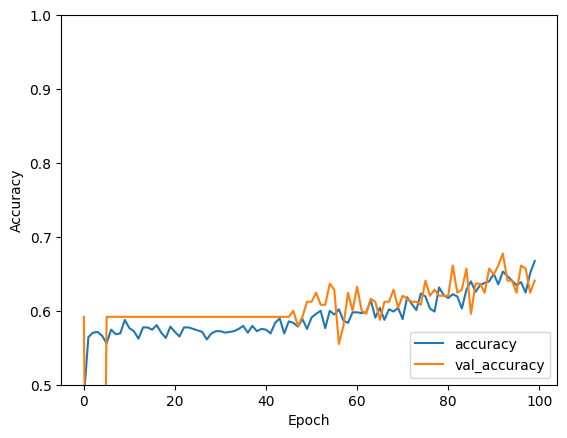

In [21]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

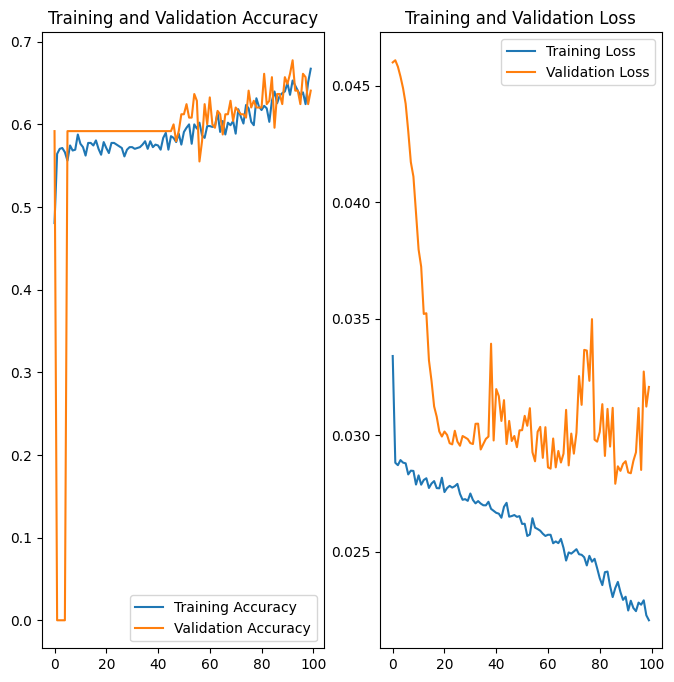

In [22]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 16))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

The Accuracy of this model is given below:

In [23]:
print(f"The accuracy of this model is: {100 * test_acc} %")

The accuracy of this model is: 64.48979377746582 %


# Saving the Model

In [24]:
model.save('./ARLP_Custom_CNN.keras')
# model.save('./ARLP_CNN.h5')

------------------------------------------

# Testing the Model

In [26]:
model = tf.keras.models.load_model('./ARLP_Custom_CNN.keras')
model.summary()

Model: "ARLP_Custom_CNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │     18,464 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 28, 28,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │      4,160 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │      4,160 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 28, 28,    │        640 │ batch_normalizat… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Concatenate)       │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 28, 28,    │      8,256 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 28, 28,    │          0 │ batch_normalizat

 Total params: 288,128,229 (1.07 GB)

 Trainable params: 96,000,353 (366.21 MB)

 Non-trainable params: 127,168 (496.75 KB)

 Optimizer params: 192,000,708 (732.42 MB)

In [27]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='ARLP_Custom_CNN_architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
path = '/kaggle/input/arlp-datasets/ARLP Datasets ver-2/train/143.jpg'
def object_detection(path):

    image = load_img(path)
    image = np.array(image,dtype=np.uint8)
    image1 = load_img(path,target_size=(224,224))

    image_arr_224 = img_to_array(image1)/255.0
    h,w,d = image.shape
    test_arr = image_arr_224.reshape(1,224,224,3)

    coords = model.predict(test_arr)

    denorm = np.array([w,w,h,h])
    coords = coords * denorm
    coords = coords.astype(np.int32)

    xmin, xmax,ymin,ymax = coords[0]
    pt1 =(xmin,ymin)
    pt2 =(xmax,ymax)
    print(pt1, pt2)
    cv2.rectangle(image,pt1,pt2,(0,255,0),3)
    return image, coords

image, cods = object_detection(path)

fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10))

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
(416, 438) (639, 519)


In [ ]:
img = np.array(load_img(path))
xmin,xmax,ymin,ymax = cods[0]
roi = img[ymin:ymax,xmin:xmax]
fig = px.imshow(roi)
fig.update_layout(width=350, height=250, margin=dict(l=10, r=10, b=10, t=10))